In [198]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, minmax_scale
full_assoc = "/Users/gabrieledele/.anydesk/incoming/2024-06-26 10:56:18.334/full_association_mtrix_sub-10339_30seeds.csv"
full_assoc = pd.read_csv(full_assoc, sep=',', header=None).to_numpy(dtype=float)

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(full_assoc)
full_scaled = scaler.transform(full_assoc)
#print(full_assoc)

In [199]:
high_4500 = "/Users/gabrieledele/.anydesk/incoming/2024-06-26 11:03:19.004/high_wm_4500_sub-10339_ts_1vol.npy"
high_1500 = "/Users/gabrieledele/.anydesk/incoming/2024-06-26 11:51:55.036/high_wm_1500_sub-10339_ts_1vol.npy"
high_3000 = "/Users/gabrieledele/.anydesk/incoming/2024-06-26 11:51:55.036/high_wm_3000_sub-10339_ts_1vol.npy"
low_1500 = "/Users/gabrieledele/.anydesk/incoming/2024-06-26 11:51:55.036/low_wm_1500_sub-10339_ts_1vol.npy"
low_3000 = "/Users/gabrieledele/.anydesk/incoming/2024-06-26 11:51:55.036/low_wm_3000_sub-10339_ts_1vol.npy"
low_4500 = "/Users/gabrieledele/.anydesk/incoming/2024-06-26 11:51:55.036/low_wm_4500_sub-10339_ts_1vol.npy"
#func = np.load(func)

In [211]:
#### right code !!!!
import sys
import os
import numpy as np
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
from scipy.stats import spearmanr, zscore, pearsonr # type: ignore
from sklearn.metrics import r2_score, mean_absolute_error # type: ignore

def activity_flow_conn(conn_array, func_array):
    
    taskActMatrix = func_array #shape parcel x timeseries x subj
    connMatrix = conn_array # shape parcel x parcel x state x subj

    numTasks = taskActMatrix.shape[1]
    numRegions = taskActMatrix.shape[0]
    numConnStates = connMatrix.shape[2]
    numSubjs = connMatrix.shape[3]

    # Setup for prediction
    taskPredMatrix = np.zeros((numRegions, numTasks, numSubjs))
    taskActualMatrix = taskActMatrix
    regionNumList = np.arange(numRegions)

    for subjNum in range(numSubjs):
        for taskNum in range(numTasks):

            # Get this subject's activation pattern for this task
            taskActVect = taskActMatrix[:, taskNum, subjNum]

            for regionNum in range(numRegions):

                # Hold out region whose activity is being predicted
                otherRegions = np.delete(regionNumList, regionNum)

                # Get this region's connectivity pattern
                if numConnStates > 1:
                    stateFCVect = connMatrix[:, regionNum, taskNum, subjNum]
                else:
                    # If using resting-state (or any single state) data
                    stateFCVect = connMatrix[:, regionNum, 0, subjNum]

                # Calculate activity flow prediction
                taskPredMatrix[regionNum, taskNum, subjNum] = np.sum(taskActVect[otherRegions] * stateFCVect[otherRegions])
            
            ## Normalize values (z-score)
            #taskPredMatrix[:, taskNum, subjNum] = zscore(taskPredMatrix[:, taskNum, subjNum])
            #taskActualMatrix[:, taskNum, subjNum] = zscore(taskActMatrix[:, taskNum, subjNum])

            # get metrics
            #pearson_corr = pearsonr(taskPredMatrix[:, taskNum, subjNum], taskActualMatrix[:, taskNum, subjNum, 0])
            #spearman_corr, spearman_p_val = spearmanr(taskPredMatrix[:, taskNum, 0], taskActualMatrix[:, taskNum, 0, 0])
            #r2 = r2_score(taskActualMatrix[:, taskNum, subjNum, 0], taskPredMatrix[:, taskNum, subjNum])
            #mae = mean_absolute_error(taskActualMatrix[:, taskNum, subjNum, 0], taskPredMatrix[:, taskNum, subjNum])
    
    return taskPredMatrix#, taskActualMatrix, pearson_corr, spearman_corr, spearman_p_val, r2, mae

def scatter_plot_func(taskPredMatrix, taskActualMatrix, spearman_corr, spearman_p_val, sub_id=None, save_dir=None):
    
    spearman_corr = float(spearman_corr)
    spearman_p_val = float(spearman_p_val)
    
    pred_values = taskPredMatrix[:, 0, 0]
    actual_values = taskActualMatrix[:, 0, 0]

    plt.figure()
    plt.scatter(range(len(pred_values)), pred_values, color='lightblue', label='Predicted Activation')
    plt.scatter(range(len(actual_values)), actual_values, color='lightcoral', label='Empirical Activation')

    plt.title(f'Predicted vs Empirical Activation for {sub_id}' if sub_id else 'Predicted vs Empirical Activation')
    plt.xlabel('Region')
    plt.ylabel('Activation')

    plt.legend(
        loc='upper left',  # position inside the plot
        bbox_to_anchor=(1.05, 1),  # move legend outside the plot
        borderaxespad=0.,
        title=f"Spearman's $\\rho$: {spearman_corr:.3f} (p={spearman_p_val:.2g})"
    )
    if save_dir and sub_id:
        save_path = f"{save_dir}/scatter_plot_{sub_id}.png"
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()
    
    return

def main(input_conn, input_func, n_seeds):

    sub_id = 'sub-10339'
    #sub_id = input_conn.split('/')[-3]
    print(sub_id)

    #base_name = os.path.basename(input_func)
    #condition = base_name.split('_sub')[0]
    condition = 'high_4500'
    conn_array = input_conn #pd.read_csv(input_conn, delimiter=',', header=None, dtype=float).to_numpy()
    func_array = np.load(input_func)

    func_array = np.expand_dims(func_array, axis=1)
    func_array = np.expand_dims(func_array, axis=2)

    conn_array = np.expand_dims(conn_array, axis=2)
    conn_array = np.expand_dims(conn_array, axis=3)
    
    taskPredMatrix = activity_flow_conn(conn_array, func_array)
    
    os.makedirs(f'derivatives/output_AFM_{condition}_{n_seeds}', exist_ok=True)
    
    metrics_path = f"derivatives/output_AFM_{condition}_{n_seeds}/eval_metrics_{sub_id}_{n_seeds}.txt"

    # save metrics in txt file
    #with open(metrics_path, 'w') as f:
    #    f.write(f"pearson_corr: {pearson_corr}\n")
    #    f.write(f"spearman_corr: {spearman_corr}\n")
    #    f.write(f"R^2: {r2}\n")
    #    f.write(f"MAE: {mae}\n")

    save_dir = f"derivatives/output_AFM_{condition}_{n_seeds}"
    os.makedirs(save_dir, exist_ok=True)

    task_pred_matrix_path = os.path.join(save_dir, f"taskPredMatrix_{sub_id}_{condition}_{n_seeds}.npy")
    np.save(task_pred_matrix_path, taskPredMatrix)
    
    #scatter_plot_func(taskPredMatrix, taskActualMatrix, spearman_corr, spearman_p_val, sub_id, save_dir)

In [212]:
#main(full_scaled, low_1500, 30)
#main(full_scaled, low_3000, 30)
#main(full_scaled, low_4500, 30)
#main(full_scaled, high_1500, 30)
#main(full_scaled, high_3000, 30) 
#main(full_scaled, high_4500, 30)


sub-10339


In [213]:
e_low_1500 = "/Users/gabrieledele/.anydesk/incoming/2024-06-26 11:51:55.036/low_wm_1500_sub-10339_ts_1vol.npy"
e_low_3000 = "/Users/gabrieledele/.anydesk/incoming/2024-06-26 11:51:55.036/low_wm_3000_sub-10339_ts_1vol.npy"
e_low_4500 = "/Users/gabrieledele/.anydesk/incoming/2024-06-26 11:51:55.036/low_wm_4500_sub-10339_ts_1vol.npy"
e_high_1500 = "/Users/gabrieledele/.anydesk/incoming/2024-06-26 11:51:55.036/high_wm_1500_sub-10339_ts_1vol.npy"
e_high_3000 = "/Users/gabrieledele/.anydesk/incoming/2024-06-26 11:51:55.036/high_wm_3000_sub-10339_ts_1vol.npy"
e_high_4500 = "/Users/gabrieledele/.anydesk/incoming/2024-06-26 11:03:19.004/high_wm_4500_sub-10339_ts_1vol.npy"

In [214]:
p_low_1500 = "/Users/gabrieledele/Desktop/GitHub/thesis-work/AFM/derivatives/output_AFM_low_1500_30/taskPredMatrix_sub-10339_low_1500_30.npy"
p_low_3000 = "/Users/gabrieledele/Desktop/GitHub/thesis-work/AFM/derivatives/output_AFM_low_3000_30/taskPredMatrix_sub-10339_low_3000_30.npy"
p_low_4500 = "/Users/gabrieledele/Desktop/GitHub/thesis-work/AFM/derivatives/output_AFM_low_4500_30/taskPredMatrix_sub-10339_low_4500_30.npy"
p_high_1500 = "/Users/gabrieledele/Desktop/GitHub/thesis-work/AFM/derivatives/output_AFM_high_1500_30/taskPredMatrix_sub-10339_high_1500_30.npy"
p_high_3000 = "/Users/gabrieledele/Desktop/GitHub/thesis-work/AFM/derivatives/output_AFM_high_3000_30/taskPredMatrix_sub-10339_high_3000_30.npy"
p_high_4500 = "/Users/gabrieledele/Desktop/GitHub/thesis-work/AFM/derivatives/output_AFM_high_4500_30/taskPredMatrix_sub-10339_high_4500_30.npy"

In [215]:
import sys
import os
import re
import numpy as np
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
from scipy.stats import spearmanr, zscore, pearsonr # type: ignore
from sklearn.metrics import r2_score, mean_absolute_error # type: ignore

def avg_contrast(p_low_1500, p_low_3000, p_low_4500, p_high_1500, p_high_3000, p_high_4500, \
                 e_low_1500, e_low_3000, e_low_4500, e_high_1500, e_high_3000, e_high_4500):
    
    # load data
    p_low_1500 = np.load(p_low_1500)
    p_low_3000 = np.load(p_low_3000)
    p_low_4500 = np.load(p_low_4500)
    p_high_1500 = np.load(p_high_1500)
    p_high_3000 = np.load(p_high_3000)
    p_high_4500 = np.load(p_high_4500)
    e_low_1500 = np.load(e_low_1500)
    e_low_3000 = np.load(e_low_3000)
    e_low_4500 = np.load(e_low_4500)
    e_high_1500 = np.load(e_high_1500)
    e_high_3000 = np.load(e_high_3000)
    e_high_4500 = np.load(e_high_4500)
    
    ## PREDICTED MATRICES
    # normalize values
    #p_low_1500 = zscore(p_low_1500)
    #p_low_3000 = zscore(p_low_3000)
    #p_low_4500 = zscore(p_low_4500)
    #p_high_1500 = zscore(p_high_1500)
    #p_high_3000 = zscore(p_high_3000)
    #p_high_4500 = zscore(p_high_4500)

    # get avg across two main conditions
    p_low_avg = (p_low_1500 + p_low_3000 + p_low_4500) / 3
    p_high_avg = (p_high_1500 + p_high_3000 + p_high_4500) / 3

    # get contrast by computing low-high
    p_diff = p_high_avg - p_low_avg
    #slice to get only relevant dimension (for correlation purposes)
    p_diff = p_diff[:, 0, 0]
    p_diff = zscore(p_diff)
    
    ## EMPIRICAL MATRICES
    
    #e_low_1500 = zscore(e_low_1500)
    #e_low_3000 = zscore(e_low_3000)
    #e_low_4500 = zscore(e_low_4500)
    #e_high_1500 = zscore(e_high_1500)
    #e_high_3000 = zscore(e_high_3000)
    #e_high_4500 = zscore(e_high_4500)
    
    e_low_avg = (e_low_1500 + e_low_3000 + e_low_4500) / 3
    e_high_avg = (e_high_1500 + e_high_3000 + e_high_4500) / 3

    # get contrast by computing low-high
    e_diff = e_high_avg - e_low_avg
    #slice to get only relevant dimension (for correlation purposes)
    e_diff = e_diff[:, 0]
    e_diff = zscore(e_diff)
    
    # compute metrics
    pearson_corr = pearsonr(p_diff, e_diff)
    spearman_corr, spearman_p_val = spearmanr(p_diff, e_diff)
    r2 = r2_score(e_diff, p_diff)
    mae = mean_absolute_error(e_diff, p_diff)

    return p_diff, e_diff, pearson_corr, spearman_corr, spearman_p_val, r2, mae

def scatter_plot_func(p_diff, e_diff, spearman_corr, spearman_p_val, sub_id=None, save_dir=None):
    
    spearman_corr = float(spearman_corr)
    spearman_p_val = float(spearman_p_val)
    
    pred_values = p_diff
    actual_values = e_diff

    plt.figure()
    plt.scatter(range(len(pred_values)), pred_values, color='lightblue', label='Predicted Activation')
    plt.scatter(range(len(actual_values)), actual_values, color='lightcoral', label='Empirical Activation')

    plt.title(f'Predicted vs Empirical Activation for {sub_id}' if sub_id else 'Predicted vs Empirical Activation')
    plt.xlabel('Region')
    plt.ylabel('Activation')

    plt.legend(
        loc='upper left',  # position inside the plot
        bbox_to_anchor=(1.05, 1),  # move legend outside the plot
        borderaxespad=0.,
        title=f"Spearman's $\\rho$: {spearman_corr:.3f} (p={spearman_p_val:.2g})"
    )
    if save_dir and sub_id:
        save_path = f"{save_dir}/scatter_plot_{sub_id}.png"
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()
    
    return

def main(p_low_1500, p_low_3000, p_low_4500, p_high_1500, p_high_3000, p_high_4500, \
         e_low_1500, e_low_3000, e_low_4500, e_high_1500, e_high_3000, e_high_4500):
    
    base_name = os.path.basename(p_low_1500)
    sub_id = "sub-10339"
    n_seeds = "30"
    p_diff, e_diff, pearson_corr, spearman_corr, spearman_p_val, r2, mae = avg_contrast(p_low_1500, p_low_3000, p_low_4500, p_high_1500, p_high_3000, p_high_4500, \
                                                                                        e_low_1500, e_low_3000, e_low_4500, e_high_1500, e_high_3000, e_high_4500)

    os.makedirs(f'derivatives/output_AFM_{n_seeds}', exist_ok=True)
    save_dir = f"derivatives/output_AFM_{n_seeds}"

    metrics_path = os.path.join(save_dir, f"eval_metrics_{sub_id}_{n_seeds}.txt")

    # save metrics in txt file
    with open(metrics_path, 'w') as f:
        f.write(f"pearson_corr: {pearson_corr}\n")
        f.write(f"spearman_corr: {spearman_corr}\n")
        f.write(f"R^2: {r2}\n")
        f.write(f"MAE: {mae}\n")

    scatter_plot_func(p_diff, e_diff, spearman_corr, spearman_p_val, sub_id, save_dir)
    return p_diff
#if __name__ == "__main__":

#    if len(sys.argv) != 13:
#        print("##################### \
#                \n Syntax error: Usage: python [this script.py] p_low_1500 p_low_3000 p_low_4500 p_high_1500 p_high_3000 p_high_4500 e_low_1500 e_low_3000 e_low_4500 e_high_1500 e_high_3000 e_high_4500 \
#                \n (e = empirical, p = predicted)")
#        sys.exit(1)
    
#    main(*sys.argv[1:])

Plot saved to derivatives/output_AFM_30/scatter_plot_sub-10339.png


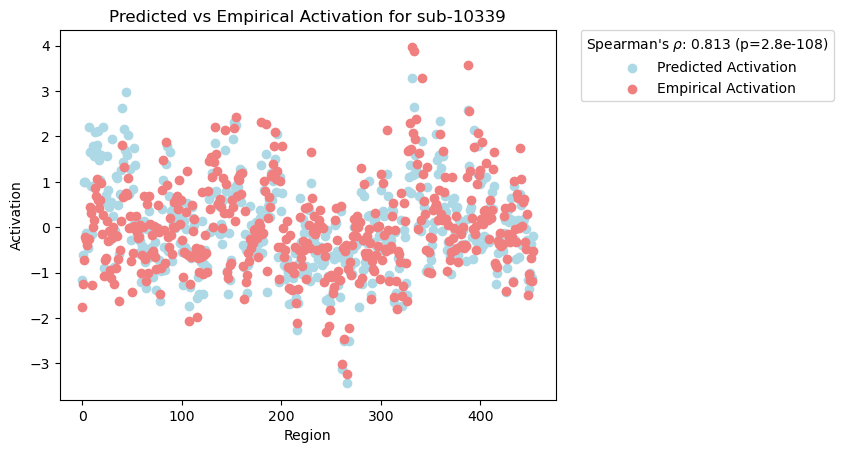

In [216]:
raw_z = main(p_low_1500, p_low_3000, p_low_4500, p_high_1500, p_high_3000, p_high_4500, e_low_1500, e_low_3000, e_low_4500, e_high_1500, e_high_3000, e_high_4500)


In [217]:
print(raw_z)
np.save("derivatives/output_AFM_30/raw_diff_resc_z", raw_z)

[-1.15663804e+00 -6.14049602e-01  9.98008861e-01  9.85410029e-01
 -1.19362585e-01 -2.50929525e-01 -4.53362831e-01  2.20148639e+00
  1.66827915e+00  9.09995892e-01 -1.48274647e-01  1.79583212e+00
  1.57560208e+00  2.10042150e+00  1.70378883e+00  1.80753188e+00
  2.12859559e+00  1.47624130e+00  1.04796839e+00  1.59036318e+00
  5.51809810e-01  2.20908562e+00 -8.97479332e-01  6.17002050e-01
  7.18146586e-01  1.57693432e+00  8.13575613e-01  4.40204585e-01
 -2.78732455e-01  5.58462828e-01  1.93388996e+00  2.40661506e-01
 -8.68197501e-01 -9.40815133e-02  1.13450687e+00  1.08901669e+00
  4.85671733e-01 -5.94549495e-01  7.29175533e-01  1.25059687e+00
  2.61836774e+00  1.43312165e+00  2.16898869e+00  1.70289600e+00
  2.97594049e+00  1.58920770e+00  2.03751927e+00  7.32182602e-01
  1.27932224e+00 -2.92320099e-01  3.60398295e-02  8.43945594e-01
  1.74195275e+00  1.37300317e+00  1.04807824e-01 -1.76766186e-01
 -5.63605989e-01 -1.64111385e-01 -3.06578479e-01 -1.19936893e+00
 -4.11866933e-01 -4.39369